# Nonstationary Extremes

As with our stationary annual extremes, for the nonstationary extremes we'll be using the Generalized Extreme Value (GEV) distribution. The GEV is a family of continuous probability distributions developed to combine the Gumbel, Fréchet, and Weibull families, also known as type I, II, and III extreme value distributions, respectively. It is widely used in different fields, particularly for modeling the largest or smallest values among a large set of independent, identically distributed random values (extreme value analysis).


### Cumulative Distribution Function (CDF)

The cumulative distribution function of the GEV, which is used to calculate return periods, is given by:

\begin{align}
F(x; \mu, \sigma, \xi) = \begin{cases} 
\exp\left(-\left(1 + \xi \frac{x - \mu}{\psi}\right)^{-\frac{1}{\xi}}\right) & \text{if } \xi \neq 0, \; 1 + \xi \frac{x - \mu}{\psi} > 0 \\
\exp\left(-\exp\left(-\frac{x - \mu}{\psi}\right)\right) & \text{if } \xi = 0
\end{cases}
\end{align}

Where:
- $\mu $ (location parameter) determines the center of the distribution.
- $ \psi $ (scale parameter) is strictly positive and scales the distribution.
- $ \xi $ (shape parameter) describes the tail behavior of the distribution. It can be positive (heavy tail, Fréchet), zero (exponential tail, Gumbel), or negative (bounded tail, Weibull).

Assuming we are not dealing with a random stationary process (as with our stationary annual extremes), each parameter in the above equation can be the combination of one or more time-dependent components. These effects could include annual variability (seasonality), sea level rise (long-term trend and possible acceleration), a long-term trend for the extreme values, long-term climate variability effects explained by climate indices or the 18.61-yr nodal cycle.

The sum total of these covariates on each parameter are:
\begin{align}
\mu(t) &= \mu_{SLR}(t) + \mu_S(t)exp^{[\mu_{LT}(t)]} + \mu_N(t) + \mu_{CLI}(t),\\
\psi_t(t) &= \psi_S(t)exp^{[\psi_{LT}(t)]} + \psi_N(t) + \psi_{CLI},\\
\xi_t(t) &= \xi_S(t)exp^{[\xi_{LT}(t)]}
\end{align}

Note this includes a nonlinear component to allow for a long-term (LT) variability in the seasonality (S) in the location and scale parameters.


This example script explores the following steps:
- step1: seasonal pattern of extreme events (seasonality on location, scale, and shape parameters remain constant)
- step2: long-term trends in location parameter (linear and a possible acceleration)
- step3: Checking Covariate (ONI index) in the GEV location parameter
- step4: Checking Covariate (ONI index) in the GEV scale parameter
- step5: Checking Nodal cycle (18.6 year period, waves) in the GEV location parameter

Author: Melisa Menendez, menendezm@unican.es

Updated for Billy & Ayesha SERDP work: 09-March-2017

Updated for Python with some added explanation: July 2024

Further explanation of this code (and writeup) can be found in:
Méndez, F. J., M. Menéndez, A. Luceño, and I. J. Losada, 2007: Analyzing Monthly Extreme Sea Levels with a Time-Dependent GEV Model. J. Atmos. Oceanic Technol., 24, 894–911, https://doi.org/10.1175/JTECH2009.1.

In [2]:
import pandas as pd
import numpy as np
import scipy.io
from datetime import datetime, timedelta
from scipy.stats import chi2
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import subprocess

## Main Functions
Here we'll write our main functions.

### Step-wise solver
This function iteratively improves the model solution by choosing which parameters to use and evaluating if the change leads to a statistically significant improvement using a $\chi^2$ metric.

In [3]:
def stepwise(x_inisol, modelType='GEV_SeasonalMu'):
    N = len(x_inisol)


    cont = 0

    x = np.array([x_inisol]) 
    # x = x_inisol # Start with initial solution
    f, pa = fitness(x[cont], modelType)  # Compute fitness for initial solution
    f = np.array([f])
    pa = np.array([pa])
    
    better = True
    prob = 0.95
    
    while better:

        dum = np.where(x[cont] == 0)[0]  # Find positions of zeros in the chromosome
        
        if dum.size != 0:
            x_temp = np.tile(x[cont], (len(dum), 1))
            f_temp = np.zeros(len(dum))
            pa_temp = np.zeros(len(dum))
            
            for i in range(len(dum)):
                x_temp[i, dum[i]] = 1
                f_temp[i], pa_temp[i] = fitness(x_temp[i], modelType)
            best, indi = np.max(f_temp), np.argmax(f_temp)
            # Check if the improvement is significant with chi2 test
            if (best - f[cont]) >= (0.5 * chi2.ppf(prob, df=(pa_temp[indi] - pa[cont]))):
                cont += 1
                x = np.vstack((x, [x_temp[indi]]))
                f = np.vstack((f, [best]))
                pa = np.vstack((pa, [pa_temp[indi]]))
                f[cont], pa[cont] = fitness(x[cont], modelType)
            else:
                better = False
        else:
            better = False

    return x, f

### Maximum Likelihood Estimation

Since we are using monthly data, we can define our location parameter as a harmonic series to represent seasonal effects, like so:

```{margin}
```{note}
Note that some portions of the original code have a dyadic series, so while our normal series would have n going from 1 to $\infty$ we will have $n=1,2,4$, representing the annual cycle, the seasonal cycle, and the '4w' cycle. (What is that - quarterly?)
```

$$
f(t) = A_0 + \sum_{n=1}^{\infty} \left( A_n \cos(2n \pi t) + B_n \sin(2n \pi t) \right),
$$



For example, if we can describe our location, scale and shape parameters in the GEV as:

\begin{align}
\mu(t) &= \beta_{SLR}(t) + [\beta_0 + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t)]e^{[\beta_{LT}(t)]}\\\
 &+ \beta_{N_1} cos(2\pi t/T_N) + \beta_{N_2} sin(2\pi t/T_N) + \beta_{ONI}ONI(t),\\
\psi(t) &= [\alpha_0 + \alpha_1 cos(2\pi t) + \alpha_2 sin(2\pi t)]e^{[\alpha_{LT}(t)]} \\
\xi(t) &=  [\gamma_0 + \gamma_1 cos(2\pi t) + \gamma_2 sin(2\pi t)]
\end{align}

then the vector we'd use for our MLE fit should be

$\theta = (\beta_0,\beta_1,\beta_2,\beta_3,\beta_4,\beta_{N_1},\beta_{N_2},\beta_{LT},\beta_{ONI},\alpha_0, \alpha_1, \alpha_2, \alpha_{LT},\gamma_0,\gamma_1,\gamma_2)$.

Here, $\beta_{0,1,2,3,4}$ model the seasonal variation of the location parameter, $\beta_{N1,N2}$ are the amplitudes of the nodal cycle, $\beta_{LT}$ is the long term trend of the location parameter, and $\beta_{ONI}$ is the amplitude (relative influence) of the [ONI] climate index in the location parameter. Similarly, $\alpha_{0,1,2}$ model the [cyclical] variation of the scale parameter, and $\alpha_{LT}$ models its long-term trend. For the shape parameter, only the seasonal variation is modeled ($\gamma_{0,1,2}$).

We'll use this vector $\theta$ to calculate the maximum likelihood function $L$,

$L(\theta | t_i,z_i) = \prod_{i=1}^m g[z_i;\mu(t_i),\psi(t_i),\xi(t_i)]$,

where $g$ is the CDF of the GEV (equation 1). In other words, this means that the likelihood of observing the entire dataset is the product of the likelihoods of observing each individual time point under the assumed GEV model (Maximum Likelihood Estimation, MLE).


### Parameter Search


The code below takes a varying number of parameters (a differently sized vector of regression parameters) for different models. There are three models we can run: GEV_SeasonalMu, GEV_S_T_Cv, or GEV_S_T_Cv_Nodal. Because there are so many parameters to estimate (a high-dimensional problem), a Shuffled Complex Evolution (SCE-UA,\cite{Duan}) optimization scheme is used to determine the best parameter fits. The SCE-UA is used often in hydrology, engineering, and other environmental sciences, using random clusters for initial starting points in its search algorithm and allowing them to "evolve" to a better solution. Other optimization schemes exist, but for now this is what we're using.

```{margin}
```{Note}
Still to do: get these models to run all in a python ecosystem. For right now, they will remain .exe files.
```

#### Seasonality in Location Model
```{margin}
The series here is n=1,2,4. WHY.
```
Our first step is to look at seasonality only, using the GEV_SeasonalMu model, such that $\mu(t)$, $\psi(t)$, and $\xi(t)$ are:

\begin{align}
\mu(t) &=  \beta_0 + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \\
&\beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) + \beta_5 cos(8\pi t) + \beta_6 sin(8\pi t),\\
\psi &= \alpha_0, \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 9 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6].$

In this way we assume that only the location parameter changes within a year, whereas the shape and scale of the GEV distribution are constant.

#### Seasonality, Trend, and Covariate Model
For the GEV_S_T_Cv model , we'll allow a long-term trend into the location parameter and a covariate into the scale and location parameter:

\begin{align}
\mu(t) &= \beta_{SLR}(t) + [\beta_0 + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) \\
&+ \beta_5 cos(6\pi t) + \beta_6 sin(6\pi t)]e^{[\beta_{LT}(t)]} + \beta_{SOI}SOI(t),\\
\psi &= \alpha_0 + \alpha_{ONI}ONI(t), \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 12 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6,\beta_{LT},\beta_{SOI},\alpha_{ONI}].$

#### Seasonality, Trend, Covariate and Nodal cycle Model
For the GEV_S_T_Cv_N model , we'll add in the nodal cycle:

\begin{align}
\mu(t) &= \beta_{SLR}(t) + [\beta_0 + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) \\
&+ \beta_5 cos(6\pi t) + \beta_6 sin(6\pi t)]e^{[\beta_{LT}(t)]} + \beta_{SOI}SOI(t) + \beta_{N_1} cos(2\pi t/T_N),\\
\psi &= \alpha_0 + \alpha_{ONI}ONI(t), \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 14 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6,\beta_{LT},\beta_{SOI},\alpha_{SOI},\beta_{N1},\beta_{N2}].$

### Input to the fitness function
Note that the input "x" to the fitness function works like a switch - if it is a parameter to include, it is 1 (True). If it is not used, it is 0 (False). It is at most 7 units long.

- x: [1/0 1/0 1/0 1/0 1/0 1/0 1/0]
- x[0]: annual cycle, location parameter.
- x[1]: semi-annual cycle, location parameter.
- x[2]: quarterly (??) cycle, location parameter.
- x[3]: Trend, location parameter.
- x[4]: Covariate, location parameter.
- x[5]: Covariate, scale parameter.
- x[6]: Nodal cycle, location parameter
- Max number of parameters: 14


In [4]:
def fitness(x, modelType='GEV_SeasonalMu'):
    # Load parameter limits from a file
    aux = np.loadtxt('limits.txt')
    xmax = np.zeros(len(aux))  # Initialize with NaNs
    xmin = np.zeros(len(aux))
    # Initialize parameter limits based on the chromosome
    xmin[:3] = aux[:3, 0]
    xmax[:3] = aux[:3, 1]
    cont = 3
    

    if x[0] == 1:  # Annual cycle
        xmin[cont:cont+2] = [aux[3, 0], aux[4, 0]]  # should use indices 3 and 4 (i.e., aux(4,1) and aux(5,1) in MATLAB)
        xmax[cont:cont+2] = [aux[3, 1], aux[4, 1]]
        cont += 2

    if x[1] == 1:  # Semiannual cycle
        xmin[cont:cont+2] = [aux[5, 0], aux[6, 0]]  # should use indices 5 and 6 (i.e., aux(6,1) and aux(7,1) in MATLAB)
        xmax[cont:cont+2] = [aux[5, 1], aux[6, 1]]
        cont += 2

    if x[2] == 1:  # Frequency 4w
        xmin[cont:cont+2] = [aux[5, 0], aux[6, 0]]  # should use indices 5 and 6 (same as Semiannual cycle)
        xmax[cont:cont+2] = [aux[5, 1], aux[6, 1]]
        cont += 2

    if modelType == 'GEV_S_T_Cv' or modelType == 'GEV_S_T_Cv_Nodal':
        if x[2] == 1:  # Frequency 4w, for some reason the limits change, so we'll replace them
            cont -= 2
            xmin[cont:cont+2] = [aux[7, 0], aux[8, 0]]  # 
            xmax[cont:cont+2] = [aux[7, 1], aux[8, 1]]
            cont += 2
        
        if x[3] == 1: # Trend in location parameter, beta_LT
            xmin[cont] = aux[9, 0]
            xmax[cont] = aux[9, 1]
            cont += 1
        
        if x[4] == 1: # Covariate in location parameter, beta_CV
            xmin[cont] = aux[10, 0]
            xmax[cont] = aux[10, 1]
            cont += 1

        if x[5] == 1: # Covariate in scale parameter, gamma_CV
            xmin[cont] = aux[11, 0]
            xmax[cont] = aux[11, 1]
            cont += 1
    
    if modelType == 'GEV_S_T_Cv_Nodal':
        if x[6] == 1: # Nodal component in location, beta_N1, beta_N2
            xmin[cont:cont+2] = [aux[12, 0], aux[13, 0]]
            xmax[cont:cont+2] = [aux[12, 1], aux[13, 1]]
            cont += 2


    xmin = xmin[:cont]
    xmax = xmax[:cont]

    # Prepare the initial values and parameter configuration file
    n = len(xmin)
    xini = np.zeros(n) + 0.001
    xini[2] = -0.001  # Specific initialization for third parameter
    
    # Prepare parameters for the external executable
    maxn = -2000 + 1500 * n #number of iterations
    kstop = 3 #number of iterations without improvement allowed
    pcento = 0.001
    ngs = np.ceil(n / 4)
    iseed = 955
    ideflt = 1
    npg = 2 * n + 1
    nps = n + 1
    nspl = 2 * n + 1
    mings = ngs
    iniflg = 1
    iprint = 0
    
    with open('scein.dat', 'w') as f:
        # Writing header with specified formatting
        f.write(f"{maxn:5g} {kstop:5g} {pcento:5.3g} {ngs:5g} {iseed:5g} {ideflt:5g}\n")
        f.write(f"{npg:5g} {nps:5g} {nspl:5g} {mings:5g} {iniflg:5g} {iprint:5g}\n")

        # Write chromosome values with better control over formatting
        x_formatted = " ".join(f"{int(value):1.0f}" for value in x[:-1]) + f" {int(x[-1]):1.0f}\n"
        f.write(x_formatted)

        # Writing parameter limits and initial guesses with specified precision
        for i in range(len(xini)):
            f.write(f"{xini[i]:15.8f} {xmin[i]:15.8f} {xmax[i]:15.8f}\n")        

    
    # Run the external model executable
    modelName = 'Model_' + modelType + '.exe'
    subprocess.run([modelName], check=True)
    
    # Read the output
    with open('best.txt', 'r') as file:
        bestf = float(file.readline().strip())
    
    return bestf, n

### Plot: Seasonality Effect on Extremes
Next we'll make an example plot of the seasonality effect on extremes. For each year day, we'll evaluate the CDF of the GEV at a return period of 50 years to get the the return levels within the year.

In [115]:
def plottingExtremeSeasonality(T0, seaLevel, w, ReturnPeriod=50, SampleRate=12):
    dx = 0.001
    t2 = np.arange(0, 1.101, dx)
    
    # Define the mu using the harmonic series
    mu = (w[0] + w[3] * np.cos(2 * np.pi * t2) + w[4] * np.sin(2 * np.pi * t2) +
          w[5] * np.cos(4 * np.pi * t2) + w[6] * np.sin(4 * np.pi * t2) +
          w[7] * np.cos(8 * np.pi * t2) + w[8] * np.sin(8 * np.pi * t2))
    psi = w[1]
    xi = w[2]
    
    # Define the time within the year
    twinthinyear =T0-np.floor(T0)
    
    T = T0
    R = ReturnPeriod
    S = SampleRate
    seaLevelS = mu - (psi/xi) * (1 - (-np.log(1 - (1/(S*R)))) ** (-xi))
    
    
    serieCV = np.ones(len(T))
    
    # Find the root of the Quantilentime function
    def Quantilentime(x):
        t00, t11 = 0.00001, 1.00001  # Define the time bounds if not globally available

        # Variables previously defined as global in MATLAB code, handled here locally
        b0, b1, b2, b3, b4, b5, b6 = w[0], w[3], w[4], w[5], w[6], w[7], w[8]
        a0, bLT, bCI, aCI, bN1, bN2 = w[1], 0, 0, 0, 0, 0
        km = 12
        dt = 0.001
        ti = np.arange(t00, t11, dt)

        # Interpolate serieCV at ti points
        serieCV2 = np.interp(ti, T, serieCV)
        # Replace NaNs with zero (np.interp does this by default if outside the bounds)
        serieCV2[np.isnan(serieCV2)] = 0

        # Define mut (location(t)) and other parameters
        mut = (b0 * np.exp(bLT * ti) +
               b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
               b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
               b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
               bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
               (bCI * serieCV2))
        # mut = (b0  +
        #        (b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
        #        b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
        #        b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti))* np.exp(bLT * ti) +
        #        bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
        #        (bCI * serieCV2))
        psi = a0 + (aCI * serieCV2)
        xit = xi

        # Calculate factor, equation 10 in Menendez and Woodworth (2009)
        factor = 0
        for i in range(len(ti)):
            h = np.maximum(1 + (xit * (x - mut[i]) / psi[i]), 0.0001) ** (-1 / xit)
            factor += h

        Pr = 1 - (1 / R)

        y = -Pr + np.exp(-km * factor * dt)
        return y
    
    x0 = w[0]
    YY50 = brentq(Quantilentime,x0-5,x0+5) # using bracketing to find the root of Quantilentime function instead of fsolve
    
    
    # Start plotting
    plt.figure()
    sss = plt.subplot(1, 1, 1)
    sss.plot(t2, np.ones(len(t2)) * YY50-STNDtoMHHW, 'k', linewidth=2, label='R=' + str(ReturnPeriod) + ' years')
    sss.plot(t2, seaLevelS-STNDtoMHHW, '--k', linewidth=2, label='Prob. R_{'+ str(ReturnPeriod)+ '} within a year')
    sss.plot(twinthinyear, seaLevel-STNDtoMHHW, '+k', markersize=5, label='Monthly maxima')
    sss.grid(True)
    plt.axis([0, 1.001, min(seaLevel-STNDtoMHHW)-(min(seaLevel-STNDtoMHHW)*0.05), max(seaLevel-STNDtoMHHW)+(max(seaLevel-STNDtoMHHW)*0.1)])
    plt.xticks(np.arange(0.08333/2, 1, 1/6), ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
    
    
    sss.legend()
    plt.ylabel('Sea level (m)')
    
    plt.savefig('SeasonalExtremeVariations.png', dpi=250)

    return sss

## Format data input to the model
Now we'll take our sea level data, extract the monthly maxima from our timeseries, and format it for input into the model. We need the yearday of each monthly maximum, and if using a covariate model (e.g. SOI, ENSO, wave height), the yearday of that index.

In [6]:
from pathlib import Path
import xarray as xr
%run ../setup.ipynb
%run ../plotting_functions.ipynb

data_dir = Path('../../data' )
output_dir = Path('../../output') 
rsl_hourly = xr.open_dataset(data_dir/ 'rsl_hawaii.nc')

rsl_hourly['sea_level_mhhw'] = 0.001*(rsl_hourly['sea_level'] - rsl_hourly['MHHW'])


Let's print the station names that correspond to order of the data, because I keep forgetting.

In [7]:
print(rsl_hourly.station_name.values)

['French Frigate' 'Midway' 'Johnston' 'Honolulu, Hawaii' 'Nawiliwili'
 'Kahului' 'Hilo, Hawaii' 'Mokuoloe' 'Barbers Point, HI' 'Kaumalapau, HI'
 'Kawaihae']


And let's select a record id ("rid") to use for the rest of this example.

In [8]:
rid = 3
STNDtoMHHW = 0.001*rsl_hourly['MHHW'][rid].values

sea_level_series = 0.001*rsl_hourly['sea_level'][rid]

#get only data from 1993 to 2023
sea_level_series = sea_level_series.sel(time=slice('1993', '2023'))

# Step 1: extract the monthly maxima
monthly_max = sea_level_series.resample(time='1ME').max()

# get exact time of the monthly maxima
t_monthly_max = sea_level_series.resample(time='1ME').map(lambda x: x.time[x.argmax()])

# To ensure it's in datetime format and to access datetime properties
t_monthly_max['time'] = pd.to_datetime(t_monthly_max.values)

# Now extract the day of the year (using fractional days)
t_yearDay = t_monthly_max['time'].dt.dayofyear + t_monthly_max['time'].dt.hour/24 + t_monthly_max['time'].dt.minute/1440 + t_monthly_max['time'].dt.second/86400

# get year of t_monthly_max
t_year = t_monthly_max['time'].dt.year

# convert t_yearDay and monthly_max to float
t_yearDay = np.array(t_yearDay)
monthly_max = np.array(monthly_max)
t_monthly_max = np.array(t_monthly_max)
t_year = np.array(t_year)


# get decimal year such that t = year_monthly_max + t_yearDay/366
t = (t_year-t_year[0]) + t_yearDay/366


# save the data to a text file for the external model
pd.Series(t).to_csv('T.txt', header=False, index=False)
pd.Series(monthly_max).to_csv('Y.txt', header=False, index=False)

#### Prepare the covariate data timeseries.
In this case, we'll be using the ONI data we downloaded earlier in the datawrangling notebook.

In [9]:
ONI_df = pd.read_csv(data_dir / 'ONI.csv', parse_dates=['Date'])

# drop last 2 columns
ONI_df = ONI_df.drop(ONI_df.columns[-2:], axis=1)

# Set the Date as the index for easier slicing and access
ONI_df.set_index('Date', inplace=True)

# Reindex to include all necessary dates from t_monthly_max for interpolation
all_dates = ONI_df.index.union(t_monthly_max)

# Reindex the DataFrame with the union of dates
ONI_df = ONI_df.reindex(all_dates)

# Now interpolate 
ONI_interp_df = ONI_df.interpolate()

# retrieve the ONI value for the monthly maxima
ONI_interp = ONI_interp_df.loc[t_monthly_max]

# save the ONI values to a text file for the external model
ONI_interp.to_csv('CI.txt', header=False, index=False)

# Save ONI_interp as 'covariate' as a 1D numpy array
covariate = ONI_interp.squeeze().to_numpy()

## First look: Modeling Seasonality
Here we'll look at seasonality in the location parameter only.

In [10]:
# Initial chromosome setup
x_0 = np.array([0,0,0])

# Run stepwise optimization and get the last results from the optimization
x_s, f = stepwise(x_0, modelType='GEV_SeasonalMu')
x, f = fitness(x_s[-1],modelType='GEV_SeasonalMu')

# Load best results from text files
w_s = np.loadtxt('best.txt')
mios = np.loadtxt('mio.txt')  # LABEL

icromo = x_s[-1]

# Prepare data for plotting
w_s_plot = np.zeros(9)
w_s_plot[:3] = w_s[1:4]

In [211]:
def adjust_w_for_plotting(icromo,w_s):
    # Adjust w_s_plot based on icromo conditions
    w_s_plot = np.zeros(14)
    w_s_plot[:3] = w_s[1:4]
    if icromo[0] == 1:
        w_s_plot[3:5] = w_s[4:6]
    if icromo[1] == 1 and icromo[0] == 0:
        w_s_plot[5:7] = w_s[4:6]
    elif icromo[1] == 1 and icromo[0] == 1:
        w_s_plot[5:7] = w_s[6:8]
    if icromo[2] == 1:
        if icromo[1] == 1 and icromo[0] == 1:
            w_s_plot[7:9] = w_s[8:10]
        elif icromo[2] == 1 and icromo[1] == 1 and icromo[0] == 0:
            w_s_plot[7:9] = w_s[6:8]
        elif icromo[2] == 1 and icromo[1] == 0 and icromo[0] == 1:
            w_s_plot[7:9] = w_s[6:8]
        elif icromo[2] == 1 and icromo[1] == 0 and icromo[0] == 0:
            w_s_plot[7:9] = w_s[4:6]
    if tuple(icromo[:7]) == (1, 1, 0, 1 , 1, 0) or tuple(icromo[:7]) == (1, 1, 0, 1, 0, 1):
        if len(icromo) == 6:
            w_s_plot[7:9] = [0,0]
            w_s_plot[9] = w_s[-2]
            if icromo[4] == 1 and icromo[5] == 0:
                w_s_plot[10:12] = [w_s[-1],0]
            elif icromo[4] == 0 and icromo[5] == 1:
                w_s_plot[10:12] = [0,w_s[-1]]
    if tuple(icromo[:8]) == (1, 1, 0, 1, 0, 0, 1):
        w_s_plot[7:14] = [0,0,w_s[-3],0,0,w_s[-2],w_s[-1]]
    return w_s_plot

In [12]:
w_s_plot = adjust_w_for_plotting(icromo,w_s_plot,w_s)

### Extract a timeseries of the time-dependent return values
For each time in a timeseries, we'll evaluate the CDF of the time-dependent GEV at a given return period to get the expected return level.

In [87]:
def getTimeDependentReturnValue(T0,serieCV0,w,ReturnPeriod):
    T=T0
    R = ReturnPeriod
    serieCV=serieCV0
    dx=0.02
    t2=np.arange(0,T[-1],dx)
    
    years = np.arange(np.floor(T[0]), np.ceil(T[-1])+1)

    psi = w[1]
    xi = w[2]


    YR=np.zeros((len(ReturnPeriod),len(years)-1))

    for idx,r in enumerate(ReturnPeriod):
        x0=w[0] #initial value of return value in the iteraction

        for i in range(len(years)-1):
            t00=years[i]
            t11=years[i+1]
            def Quantilentime(x):

                # Variables previously defined as global in MATLAB, handled here locally
                b0, b1, b2, b3, b4, b5, b6 = w[0], w[3], w[4], w[5], w[6], w[7], w[8]
                a0 = w[1]
                km = 12
                dt = 0.001
                ti = np.arange(t00, t11, dt)
                bLT= 0
                bCI= 0
                aCI= 0
                bN1=0
                bN2=0

                if len(w)>=10:
                    bLT=w[9] #trend in location parameter
                if len(w)>=11:    
                    bCI=w[10] #covariate in location parameter
                if len(w)>=12:    
                    aCI=w[11] #covariate in scale parameter
                if len(w)>=13:
                    bN1=w[12]
                    bN2=w[13]

                # Interpolate serieCV at ti points
                serieCV2 = np.interp(ti, T, serieCV)
                # Replace NaNs with zero (np.interp does this by default if outside the bounds)
                serieCV2[np.isnan(serieCV2)] = 0
                # Define mut and other parameters
                # mut = (b0 * np.exp(bLT * ti) +
                #        b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
                #        b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
                #        b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
                #        bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
                #        (bCI * serieCV2))
                mut = ((b0  +
                       b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
                       b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
                       b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti))* np.exp(bLT * ti) + 
                       bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
                       (bCI * serieCV2))
                psi = a0 + (aCI * serieCV2)
                xit = xi

                # Calculate factor
                factor = 0
                for i in range(len(ti)):
                    h = np.maximum(1 + (xit * (x - mut[i]) / psi[i]), 0.0001) ** (-1 / xit)
                    factor += h
                Pr = 1 - (1 / r)
                y = -Pr + np.exp(-km * factor * dt)
                return y

            YR[idx,i]=brentq(Quantilentime,x0-2,x0+2)
            x0=YR[idx,i]
    return years, YR

#### Plot monthly extremes and 50 year return period with the seasonal model

In [113]:
w_s_plot[0]

np.float64(1.9042487)

Text(0.5, 1.0, 'Sea level extremes at Honolulu, Hawaii')

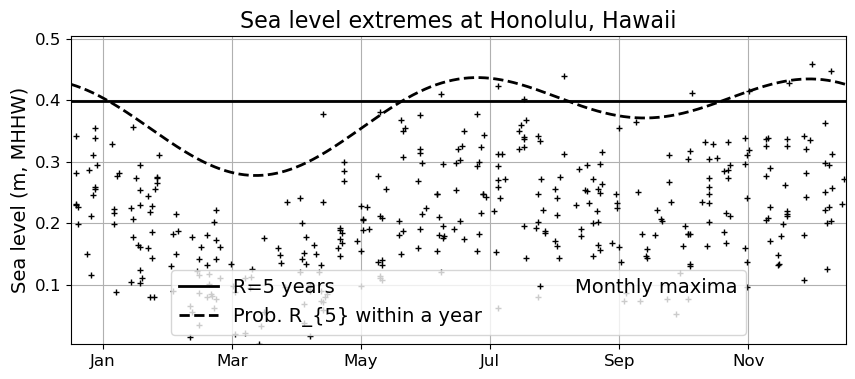

In [122]:
sss = plottingExtremeSeasonality(t,monthly_max,w_s_plot,ReturnPeriod=5,SampleRate=12)

sss.set_ylabel('Sea level (m, MHHW)')

#move legend to center top, with 2 columns
sss.legend(loc='lower center', ncol=2)

sss.set_title('Sea level extremes at ' + rsl_hourly.station_name.values[rid])


#### Check if we should include a long-term trend (mean sea level rise) in our location parameter
I mean, it's probably statistically significant, but hey, we should test just in case.

In [129]:
from scipy.stats import chi2

x_T = np.concatenate((x_s[-1], [1, 0, 0]))  # Long-term Trend

f_T = fitness(x_T, modelType='GEV_S_T_Cv')
w_T = np.loadtxt('best.txt')
miot = np.loadtxt('mio.txt')

aux = np.loadtxt('limits.txt')
# check to see if within limits
wT = w_T[1:]
for j in range(1, len(wT)):
    if wT[j] == aux[j, 0] or wT[j] == aux[j, 1]:
        raise ValueError(f'Trend Run: Parameter #{j} is at the limit: {wT[j]}')

diffe = w_T[0] - w_s[0]
p = 1
SignifTrend = chi2.cdf(2 * diffe, p)

print(f'Statistical Significance of Linear Trend: {SignifTrend*100:.2f}%')
print(f'Estimated Trend on monthly Maxima values is: {w_T[2]*w_T[-1]*1000:.2f} mm/year')
print(f'x_s is: {x_s[-1]}')
print(f'x_T is: {x_T}')
print(f'w_T is: {w_T}')

Statistical Significance of Linear Trend: 100.00%
Estimated Trend on monthly Maxima values is: 0.11 mm/year
x_s is: [1 1 0]
x_T is: [1 1 0 1 0 0]
w_T is: [ 4.67039758e+02  1.85962112e+00  6.66646400e-02 -2.22472000e-01
 -4.22099000e-03 -4.67291700e-02  5.26789800e-02 -6.08231000e-03
  1.59690000e-03]


#### Check the covariate in the location parameter.
Let's check if the covariate inclusion in the location parameter is statistically significant.

In [70]:
if SignifTrend > 0.95:
    x_cvte1 = np.concatenate((x_s[-1], [1, 1, 0]))  # Covariate
    wcomp = w_T.copy()
else:
    x_cvte1 = np.concatenate((x_s[-1], [0, 1, 0]))
    wcomp = w_s.copy()

f_cvte1 = fitness(x_cvte1, modelType='GEV_S_T_Cv')
w_cvte1 = np.loadtxt('best.txt')
mioc = np.loadtxt('mio.txt')

diffe = w_cvte1[0] - wcomp[0]
p = 1
SignifCvte1 = chi2.cdf(2 * diffe, p)
print(f'Statistical Significance of Covariate in location param.: {SignifCvte1*100:.2f}%')
print(f'x_cvte1 is: {x_cvte1}')

Statistical Significance of Covariate in location param.: 54.60%
x_cvte1 is: [1 1 0 1 1 0]


#### Check the covariate in scale parameter
Let's check if the covariate inclusion in the scale parameter is statistically significant.

In [71]:
if SignifCvte1 > 0.95:
    x_cvte2 = np.concatenate((x_cvte1[:-1], [1]))  # Covariate
    wcomp = w_cvte1.copy()
else:
    x_cvte2 = np.concatenate((x_cvte1[:-2], [0, 1]))  # Covariate
    wcomp = wcomp.copy()

f_cvte2 = fitness(x_cvte2, modelType='GEV_S_T_Cv')
w_cvte2 = np.loadtxt('best.txt')
mioc2 = np.loadtxt('mio.txt')

diffe = w_cvte2[0] - wcomp[0]
p = 1
SignifCvte2 = chi2.cdf(2 * diffe, p)

print(f'Statistical Significance of Covariate in scale param.: {SignifCvte2*100:.2f}%')
print(f'x_cvte2 is: {x_cvte2}')


Statistical Significance of Covariate in scale param.: 40.86%
x_cvte2 is: [1 1 0 1 0 1]


#### Check the nodal cycle in Location parameter
We will only include the nodal cycle in our final model if adding it significantly improves our model thus far. We will add it to the long-term trend model if the long-term trend is significant.

In [73]:
if SignifTrend>0.95:
    x_N=np.append(x_T , [1])
    wcomp=w_T.copy()
    print('The trend is significant! \nInclude long-term trend and nodal cycle in final model.')
else:
    x_N=np.append(x_s[-1],[0, 0, 0, 1])
    wcomp=w_s.copy()
    miot =mios.copy() 

fitness(x_N,modelType='GEV_S_T_Cv_Nodal');
print(f'x_N is: {x_N}')

w_N = np.loadtxt('best.txt');
mion = np.loadtxt('mio.txt');

wN = w_N[1:]
for j in range(1, len(wN)):
    if wN[j] == aux[j, 0] or wN[j] == aux[j, 1]:
        raise ValueError(f'Nodal Run: Parameter #{j} is at the limit: {wN[j]}')
    

diffe = w_N[0] - wcomp[0]
p = 2
SignifN = chi2.cdf(2 * diffe, p)

print(f'Statistical Significance of adding Nodal cycle: {SignifN*100:.2f}%')

xcromo = x_N.copy()
wc = w_N.copy()
mio = mion.copy()
if SignifN<0.95:
    xcromo[-1] = 0 # set the nodal component to zero
    wc = wcomp.copy() # use the previous model
    mio = miot

# Assess standard errors of the parameters
J = np.linalg.inv(mio)
standard_error = np.sqrt(np.diag(J))
print(f'w_N: {wc}')

The trend is significant! 
Include long-term trend and nodal cycle in final model.
x_N is: [1 1 0 1 0 0 1]
Statistical Significance of adding Nodal cycle: 99.88%
w_N: [ 4.7373511e+02  1.8658365e+00  6.5572790e-02 -2.2047758e-01
 -3.7349800e-03 -4.6138760e-02  5.3018100e-02 -5.4962600e-03
  1.3941500e-03 -1.5960120e-02 -8.2272200e-03]


## Plot the timeseries

```{margin}
```{warning}
Something is off in the plotting code.
```

In [154]:
x_cvte1

array([1, 1, 0, 1, 1, 0])

[ 1.85948129e+00  6.66563900e-02 -2.23241300e-01 -4.34724000e-03
 -4.68163900e-02  5.26746400e-02 -6.31040000e-03  0.00000000e+00
  0.00000000e+00  1.59789000e-03 -3.05871000e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[ 1.85980728e+00  6.65007700e-02 -2.20907310e-01 -4.56656000e-03
 -4.65019800e-02  5.22530300e-02 -5.81734000e-03  0.00000000e+00
  0.00000000e+00  1.58449000e-03  0.00000000e+00 -1.85746000e-03
  0.00000000e+00  0.00000000e+00]


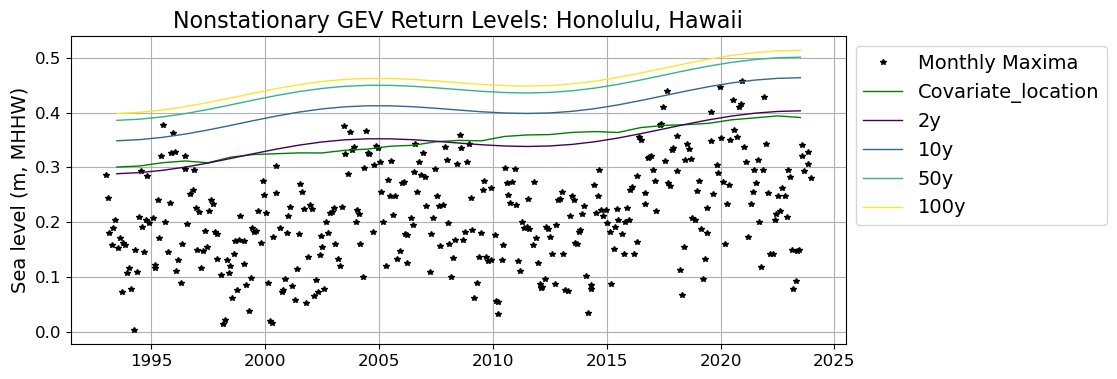

In [216]:
# %%

# get the first year of t_monthly_max
year0 = 1993

fig = plt.figure()
sss = fig.add_subplot(1, 1, 1)
sss.plot(t+year0, monthly_max-STNDtoMHHW, '*k', markersize=4, label='Monthly Maxima')

# # Plotting model with only time-dependency within the year (Seasonality only)
# best_param = np.append(w_s[1:], [0, 0, 0])
# ReturnPeriod = [2,10,50,100]
# years, Yr_s = getTimeDependentReturnValue(t, covariate, best_param,ReturnPeriod)
# for i in range(len(ReturnPeriod)):
#     sss.plot(years[:-1]+0.5+year0, Yr_s[i]-STNDtoMHHW, 'k', linewidth=2, label='S, '+str(ReturnPeriod[i])+'y')

# # Plotting model with Seasonality & Trend
best_param = np.append(w_T[1:-1], [0, 0, w_T[-1], 0, 0])
# print(best_param)
# years, Yr_T = getTimeDependentReturnValue(t, covariate, best_param,ReturnPeriod)
# for i in range(len(ReturnPeriod)):
#     sss.plot(years[:-1]+0.5+year0, Yr_T[i]-STNDtoMHHW, 'b', linewidth=2, label='S,T:' + str(ReturnPeriod[i])+'y')

# Plotting cvte influence in location
best_smu = adjust_w_for_plotting(x_cvte1,w_cvte1)
print(best_smu)
years, Yr_sigMu = getTimeDependentReturnValue(t, covariate, best_smu,ReturnPeriod)
sss.plot(years[:-1]+0.5+year0, Yr_sigMu[0]-STNDtoMHHW, 'g', linewidth=1, label='Covariate_location')

# Plotting cvte influence in scale
best_spsi = adjust_w_for_plotting(x_cvte2, w_cvte2)
print(best_spsi)
years, Yr_sigPsi = getTimeDependentReturnValue(t, covariate, best_spsi,ReturnPeriod)
# sss.plot(years[:-1]+0.5+year0, Yr_sigPsi[0]-STNDtoMHHW, 'c', linewidth=1, label='Covariate_scale')

# Plotting nodal cycle in location, will need to add back in the covariate terms as zeros
best_MuN = adjust_w_for_plotting(x_N,w_N)
years, Yr_muN = getTimeDependentReturnValue(t, covariate, best_MuN,ReturnPeriod)
cmap = plt.get_cmap('viridis')

# Generate a list of colors from the colormap
colors = [cmap(i / (len(ReturnPeriod) - 1)) for i in range(len(ReturnPeriod))]

for i in range(len(ReturnPeriod)):
    color = cmap(i)
    sss.plot(years[:-1]+0.5+year0, Yr_muN[i]-STNDtoMHHW, color=colors[i], linewidth=1, label=str(ReturnPeriod[i])+'y')

sss.set_ylabel('Sea level (m, MHHW)')
# add grid
sss.grid(True)
# add legend outside the plot
sss.legend(loc='upper left', bbox_to_anchor=(1, 1))

# add title of station name
sss.set_title('Nonstationary GEV Return Levels: ' + rsl_hourly.station_name.values[rid])

# save the figure
plt.savefig('TimeDependentReturnValue.png', dpi=250)
